In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

np.set_printoptions(threshold=np.inf)
plt.style.use('ggplot')

## ReadDataset

In [2]:
arr = np.genfromtxt('tic-tac-toe.data', delimiter=',', dtype='<U1')

## Split train&test

In [3]:
X = arr[:, :9]
y = arr[:, 9]

X.shape, y.shape

((958, 9), (958,))

## Rotate

In [4]:
X_rotate = []
X_flip_rotate = []

for i in range(4):
    X_matrix = X.reshape(-1, 3, 3)
    X_matrix_flip = np.fliplr(X_matrix)
    for i in range(X_matrix.shape[0]):

        x_rotate = np.rot90(X_matrix[i], i).reshape(-1, 9)
        X_rotate.append(x_rotate)
        
        x_flip_rotate = np.rot90(X_matrix_flip[i], i).reshape(-1, 9)
        X_flip_rotate.append(x_flip_rotate)        
    
a = np.array(X_rotate).reshape(-1, 9)
b = np.array(X_flip_rotate).reshape(-1, 9)
X = np.append(a, b, axis=0)

y = np.tile(y, 8)

X.shape, y.shape

((7664, 9), (7664,))

## Remove Duplicate after rotate

In [5]:
X, index = np.unique(X, axis=0, return_index=True)
y = y[index]

X.shape, y.shape

((879, 9), (879,))

## Shuffle

In [6]:
random_state = 0

np.random.seed(random_state)
np.random.shuffle(X)

np.random.seed(random_state)
np.random.shuffle(y)

X.shape, y.shape

((879, 9), (879,))

## LabelEncoder

In [7]:
feature = np.unique(X)
inx = np.arange(feature.shape[0])
search = np.searchsorted(feature, X)
X = inx[search]

uni = np.unique(y)
inx = np.arange(uni.shape[0])
search = np.searchsorted(uni, y)
y = inx[search].reshape(-1, 1)

X.shape, y.shape

((879, 9), (879, 1))

## OneHotEncoder

In [8]:
n_feature = feature.shape[0]
one_hot = np.zeros((X.shape[0], X.shape[1], n_feature))
for i, unique_value in enumerate(np.unique(X)):
    one_hot[:, :, i][X == unique_value] = 1

X = one_hot.reshape(-1, n_feature*X.shape[1])

X.shape

(879, 27)

## Split

In [9]:
train_split = 0.8
sample = int(train_split*y.shape[0])

X_train, X_test = X[:sample], X[sample:]
y_train, y_test = y[:sample], y[sample:]

X_train.shape, X_test.shape

((703, 27), (176, 27))

## Model

In [10]:
def create_model(neurons=(16, 16), lr=0.1, momentum=0.8):
    model = Sequential()

    model.add(Dense(neurons[0], activation='relu', input_shape=(X_train.shape[1:])))
    model.add(Dense(neurons[1], activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = SGD(lr=lr, decay=1e-6, momentum=momentum, nesterov=True)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [11]:
model = create_model()
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                448       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


## Train

In [12]:
batch_size = 16
epochs = 40

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))

Train on 703 samples, validate on 176 samples
Epoch 1/40
703/703 [==============================] - 0s 189us/sample - loss: 0.6456 - acc: 0.6373 - val_loss: 0.5745 - val_acc: 0.7159
Epoch 2/40
703/703 [==============================] - 0s 62us/sample - loss: 0.5448 - acc: 0.7084 - val_loss: 0.5240 - val_acc: 0.7102
Epoch 3/40
703/703 [==============================] - 0s 62us/sample - loss: 0.4453 - acc: 0.7767 - val_loss: 0.3952 - val_acc: 0.8011
Epoch 4/40
703/703 [==============================] - 0s 59us/sample - loss: 0.3174 - acc: 0.8691 - val_loss: 0.2581 - val_acc: 0.8864
Epoch 5/40
703/703 [==============================] - 0s 59us/sample - loss: 0.2424 - acc: 0.9104 - val_loss: 0.1186 - val_acc: 0.9545
Epoch 6/40
703/703 [==============================] - 0s 62us/sample - loss: 0.1311 - acc: 0.9644 - val_loss: 0.1047 - val_acc: 0.9659
Epoch 7/40
703/703 [==============================] - 0s 61us/sample - loss: 0.2219 - acc: 0.9360 - val_loss: 0.0962 - val_acc: 0.9773
Epoch 8/

## Training accuracy and Training Loss Graph 

Text(0, 0.5, 'Training loss')

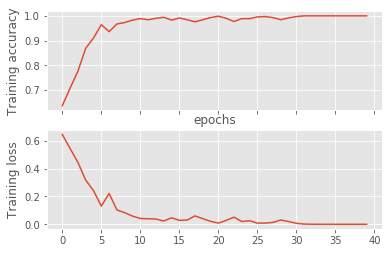

In [13]:
fig, ax = plt.subplots(2, sharex=True)

ax[0].plot(history.history['acc'], label=model)
ax[1].plot(history.history['loss'], label=model)
 
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('Training accuracy')
ax[1].set_ylabel('Training loss')

## Evaluate

In [14]:
score = model.evaluate(X_test, y_test)

176/176 [==============================] - 0s 24us/sample - loss: 0.0332 - acc: 0.9943


## GridSearch

In [15]:
param_grid = {
    'neurons' : [(8, 8), (16, 16)],
    'lr' : [0.01, 0.1],
    'momentum' : [0.8, 0.9],
    'batch_size' : [8, 16],
    'epochs' : [40],
}

In [16]:
model = KerasClassifier(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

print(grid_result.best_score_, grid_result.best_params_)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print(f'{mean} ({stdev}) with: {param}')

0.981489360332489 {'batch_size': 16, 'epochs': 40, 'lr': 0.1, 'momentum': 0.8, 'neurons': (16, 16)}
0.9701418399810791 (0.008233010532322158) with: {'batch_size': 8, 'epochs': 40, 'lr': 0.01, 'momentum': 0.8, 'neurons': (8, 8)}
0.9786727428436279 (0.010015752739354278) with: {'batch_size': 8, 'epochs': 40, 'lr': 0.01, 'momentum': 0.8, 'neurons': (16, 16)}
0.9686929941177368 (0.012447539965963702) with: {'batch_size': 8, 'epochs': 40, 'lr': 0.01, 'momentum': 0.9, 'neurons': (8, 8)}
0.9786524891853332 (0.010087516398055751) with: {'batch_size': 8, 'epochs': 40, 'lr': 0.01, 'momentum': 0.9, 'neurons': (16, 16)}
0.9715501666069031 (0.014194904006463288) with: {'batch_size': 8, 'epochs': 40, 'lr': 0.1, 'momentum': 0.8, 'neurons': (8, 8)}
0.9758156061172485 (0.003500290352186681) with: {'batch_size': 8, 'epochs': 40, 'lr': 0.1, 'momentum': 0.8, 'neurons': (16, 16)}
0.974376893043518 (0.02043147295174164) with: {'batch_size': 8, 'epochs': 40, 'lr': 0.1, 'momentum': 0.9, 'neurons': (8, 8)}
0.9

## Average test accuracy rate in 10 times

In [17]:
scores = []
for i in range(12):
    model = create_model()
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)
    print(f'Train - loss: {history.history["loss"][-1]} - acc: {history.history["acc"][-1]}')

    score = model.evaluate(X_test, y_test)
    scores.append(score[1])

scores = np.array(scores)

'Max accuracy rate :', scores.max(), 'Avg accuracy rate :', np.average(scores), 'Min accuracy rate :', scores.min()

Train - loss: 0.0005334856600278245 - acc: 1.0
176/176 [==============================] - 0s 120us/sample - loss: 0.0404 - acc: 0.9830
Train - loss: 0.0009029298858569246 - acc: 1.0
176/176 [==============================] - 0s 130us/sample - loss: 0.0739 - acc: 0.9886
Train - loss: 0.00045473195723453615 - acc: 1.0
176/176 [==============================] - 0s 148us/sample - loss: 0.0269 - acc: 0.9886
Train - loss: 0.00035660695192284196 - acc: 1.0
176/176 [==============================] - 0s 164us/sample - loss: 0.0095 - acc: 0.9943
Train - loss: 0.0004806314827874303 - acc: 1.0
176/176 [==============================] - 0s 176us/sample - loss: 0.0396 - acc: 0.9886
Train - loss: 0.0009019561924495215 - acc: 1.0
176/176 [==============================] - 0s 195us/sample - loss: 0.0933 - acc: 0.9773
Train - loss: 0.0025193482156405603 - acc: 1.0
176/176 [==============================] - 0s 209us/sample - loss: 0.0345 - acc: 0.9830
Train - loss: 0.000359121065125491 - acc: 1.0
176/176

('Max accuracy rate :',
 0.9943182,
 'Avg accuracy rate :',
 0.98721594,
 'Min accuracy rate :',
 0.97727275)